In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import re
from descartes import PolygonPatch
plotly.tools.set_credentials_file(username='pacoanes', api_key='5oW2wBsYr0Gv6euPzitK')
data = pd.read_csv('GSAF5.csv', engine='python')


Voy a realizar una breve limpieza para poder hacer un analisis rapido y poder plantearme una hipotesis. Para ello limpiare las fechas para obtener años y meses.

In [2]:
#miro la forma para ver de que esta compuesta
data.shape

(5992, 24)

In [3]:
#analizo los elementos nulos de cada columna
null_cols = data.isnull().sum()


In [4]:
#Elimino las columnas que no necesito
datan = data.drop(columns=['Unnamed: 22', 'Unnamed: 23', 'Investigator or Source','pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'Species ', 'Time'])

In [5]:
#Elimino los años que estan a cero
datani = datan[datan.Year != 0]

Vamos a analizar los ataques de los ultimos años.

In [6]:
datanis = datani[datani.Year > 1940]

LImpiaremos la fecha para obtener meses

In [7]:
datanis['Date'] = datanis['Date'].str.replace('-', ' ')
datanis['Date'] = datanis['Date'].str.replace('\d+', '')
datanis['Date'] = datanis['Date'].str.replace('Reported', '')
datanis['Date'] = datanis['Date'].str.replace('Early', '')
datanis['Date'] = datanis['Date'].str.replace('Late', '')
datanis['Date'] = datanis['Date'].str.replace(' ', '')
datanis['Date'] = datanis['Date'].str.replace('Summer, summer, summerof ', '')

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [8]:
df = datanis[datanis.Date != ""]

In [9]:
df2 = df[df["Date"].isin(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep','Oct','Nov','Dec'])]

Limpiaremos otras columnas mas sencillas como el sexo y la de ataques.

In [10]:
dasa = df2.drop(columns=['Case Number','Location','Name','Age'])

In [11]:
dasa=dasa.rename(columns = {'Sex ':'Sex'})
dasa=dasa.rename(columns = {'Fatal (Y/N)':'Fatal'})
dasa=dasa.rename(columns = {'Date':'Month'})

In [12]:
dasa1 = dasa[dasa["Sex"].isin(['M', 'F'])]

In [13]:
dasa1['Fatal'] = dasa1['Fatal'].str.replace(' N', 'N')

/usr/local/Cellar/ipython/7.3.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Ahora mismo ya tenemos un dataset minimo para poder realizar consulta y al que podemos volver mas tarde para volver a limpiar si queremos usar informacion como las actividades o el tipo de daño provocado 

In [14]:
dasa1.head()

,Month,Year,Type,Country,Area,Activity,Sex,Injury,Fatal,original order
0,Sep,2016,Unprovoked,USA,Florida,Surfing,M,Minor injury to thigh,N,5993
1,Sep,2016,Unprovoked,USA,Florida,Surfing,M,Lacerations to hands,N,5992
2,Sep,2016,Unprovoked,USA,Florida,Surfing,M,Lacerations to lower leg,N,5991
3,Sep,2016,Unprovoked,AUSTRALIA,Victoria,Surfing,M,Struck by fin on chest & leg,N,5990
4,Sep,2016,Unprovoked,AUSTRALIA,Victoria,Surfing,M,No injury: Knocked off board by shark,N,5989


Convertimos el dataframe en un csv

In [15]:
dasa.to_csv('cleaned.csv')

In [16]:
nuevo = dasa.drop(columns=['Type', 'Area', 'Activity', 'Injury', 'Sex', 'original order', 'Month'])
#nuevo['Frate'] =
cuantos=nuevo.groupby(['Country','Fatal']).count() 
ss=nuevo.Country.str.lower()
nuevo.Country=ss
nuevo['Country'] = nuevo['Country'].str.replace('usa', 'united states')
nuevo2=nuevo
#nuevo.Country.value_counts().head(30)
#nuevo2 = nuevo[nuevo["Country"].isin(['united states of america','australia','south africa','brazil','papua new guinea','bahamas','new zealand','mexico', 'reunion','new caledonia','italy','fiji', 'mozambique', 'philippines', 'japan', 'egypt',  ])]

In [17]:
paises = pd.read_csv('paises.csv', engine='python')
paises = paises.drop([paises.columns[2], paises.columns[3]], axis='columns')
pais=paises.drop_duplicates()
lo=pais.Entity.str.lower()
pais.Entity=lo


/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [18]:
shapefile = 'ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])
code = gdf.country_code.to_list()
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,United Republic of Tanzania,TZA,POLYGON ((33.90371119710453 -0.950000000000000...
2,Western Sahara,SAH,POLYGON ((-8.665589565454809 27.65642588959236...
3,Canada,CAN,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,United States of America,USA,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [19]:
#nuevo2 debe contener el code
#pais es el que hay que mergear
merged = nuevo2.merge(pais, left_on = 'Country', right_on = 'Entity')
#merged.Country.value_counts()
merged['Fatal'] = merged['Fatal'].str.replace(' N', 'N')

In [20]:
merged['Fatal'].fillna('UNKNOWN', inplace=True)

In [21]:
mergeado = merged.drop(columns=['Entity'])

In [22]:
mergeado2 = pd.DataFrame()
mergeado2["dead"] = mergeado[mergeado["Fatal"]=="Y"].groupby(["Country", "Code"]).count()["Fatal"]
mergeado2["no dead"] = mergeado[mergeado["Fatal"]=="N"].groupby(["Country", "Code"]).count()["Fatal"]
mergeado2["no dead"].fillna(0, inplace=True)
mergeado2["frate"] = mergeado2["dead"]/ (mergeado2["dead"]+ mergeado2["no dead"])
mergeado2
merga=mergeado2.drop(columns=["dead", "no dead"])
prueba = mergeado2.drop(columns=["dead", "frate"])

In [23]:
mergeado3 = mergeado2.reset_index().rename_axis(None).rename_axis(None, axis=1)

In [52]:

mergeado3.to_csv("ataqueporpais.csv")
mergeado3.head()

,Country,Code,dead,no dead,frate
0,australia,AUS,141,635.0,0.181701
1,bahamas,BHS,7,77.0,0.083333
2,bangladesh,BGD,1,0.0,1.000000
3,belize,BLZ,1,1.0,0.500000
4,brazil,BRA,38,58.0,0.395833


In [25]:
prueba = mergeado

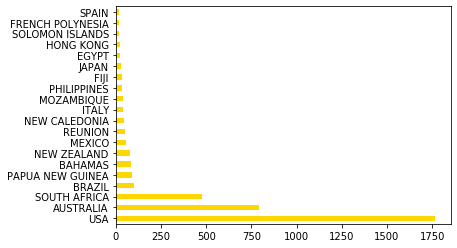

In [26]:
#vuelvo con dasa para ver que pais sufre más ataques
paisataque = dasa['Country'].value_counts().head(20)
%matplotlib inline
paisataque.plot.barh(color='gold')

Paises con mayor ataques

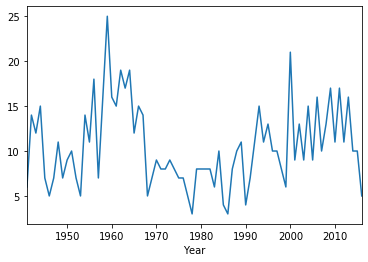

In [27]:
%matplotlib inline
dasa[dasa["Fatal"]=="Y"].groupby(["Year"]).count()['Fatal'].plot()

Muertes por año

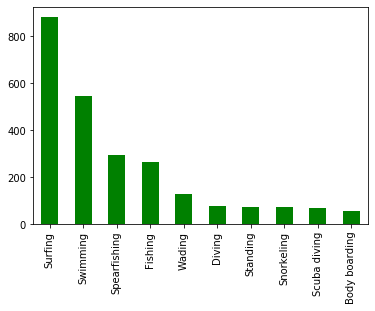

In [28]:
actataque = dasa['Activity'].value_counts().head(10)
%matplotlib inline
actataque.plot.bar(color='green')

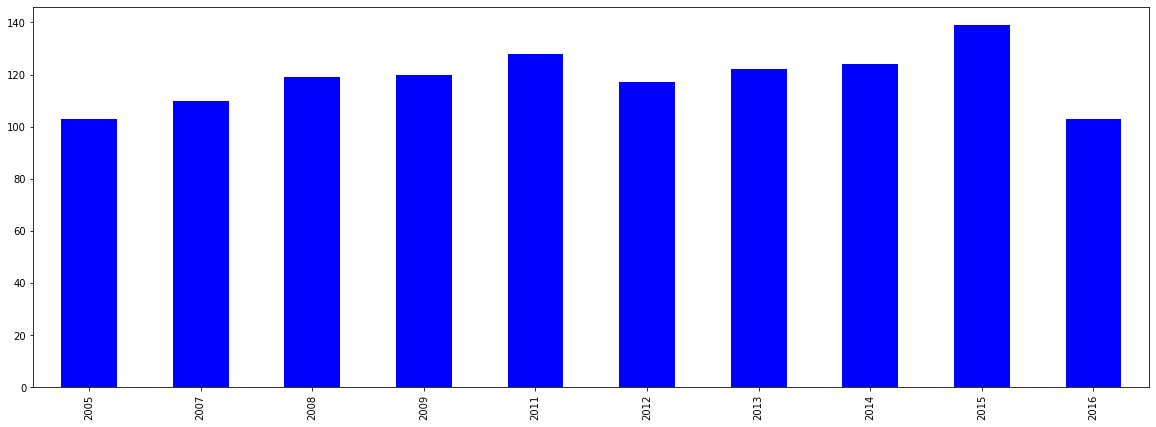

In [29]:
topyear = dasa['Year'].value_counts().head(10).sort_index()
%matplotlib inline
topyear.plot.bar(color='blue', figsize=(20, 7))

Top ten years attack

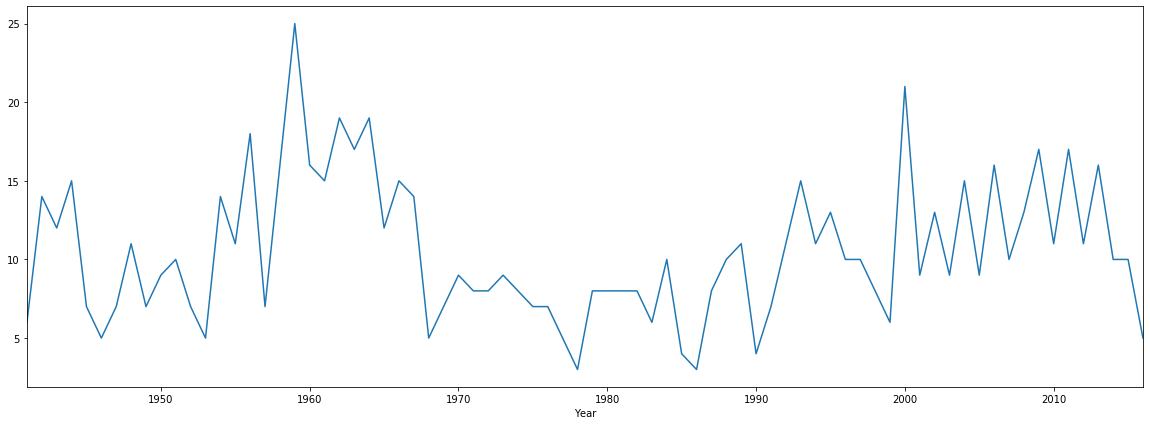

In [30]:
dasa[dasa["Fatal"]=="Y"].groupby(["Year"]).count()['Fatal'].plot(figsize=(20, 7))

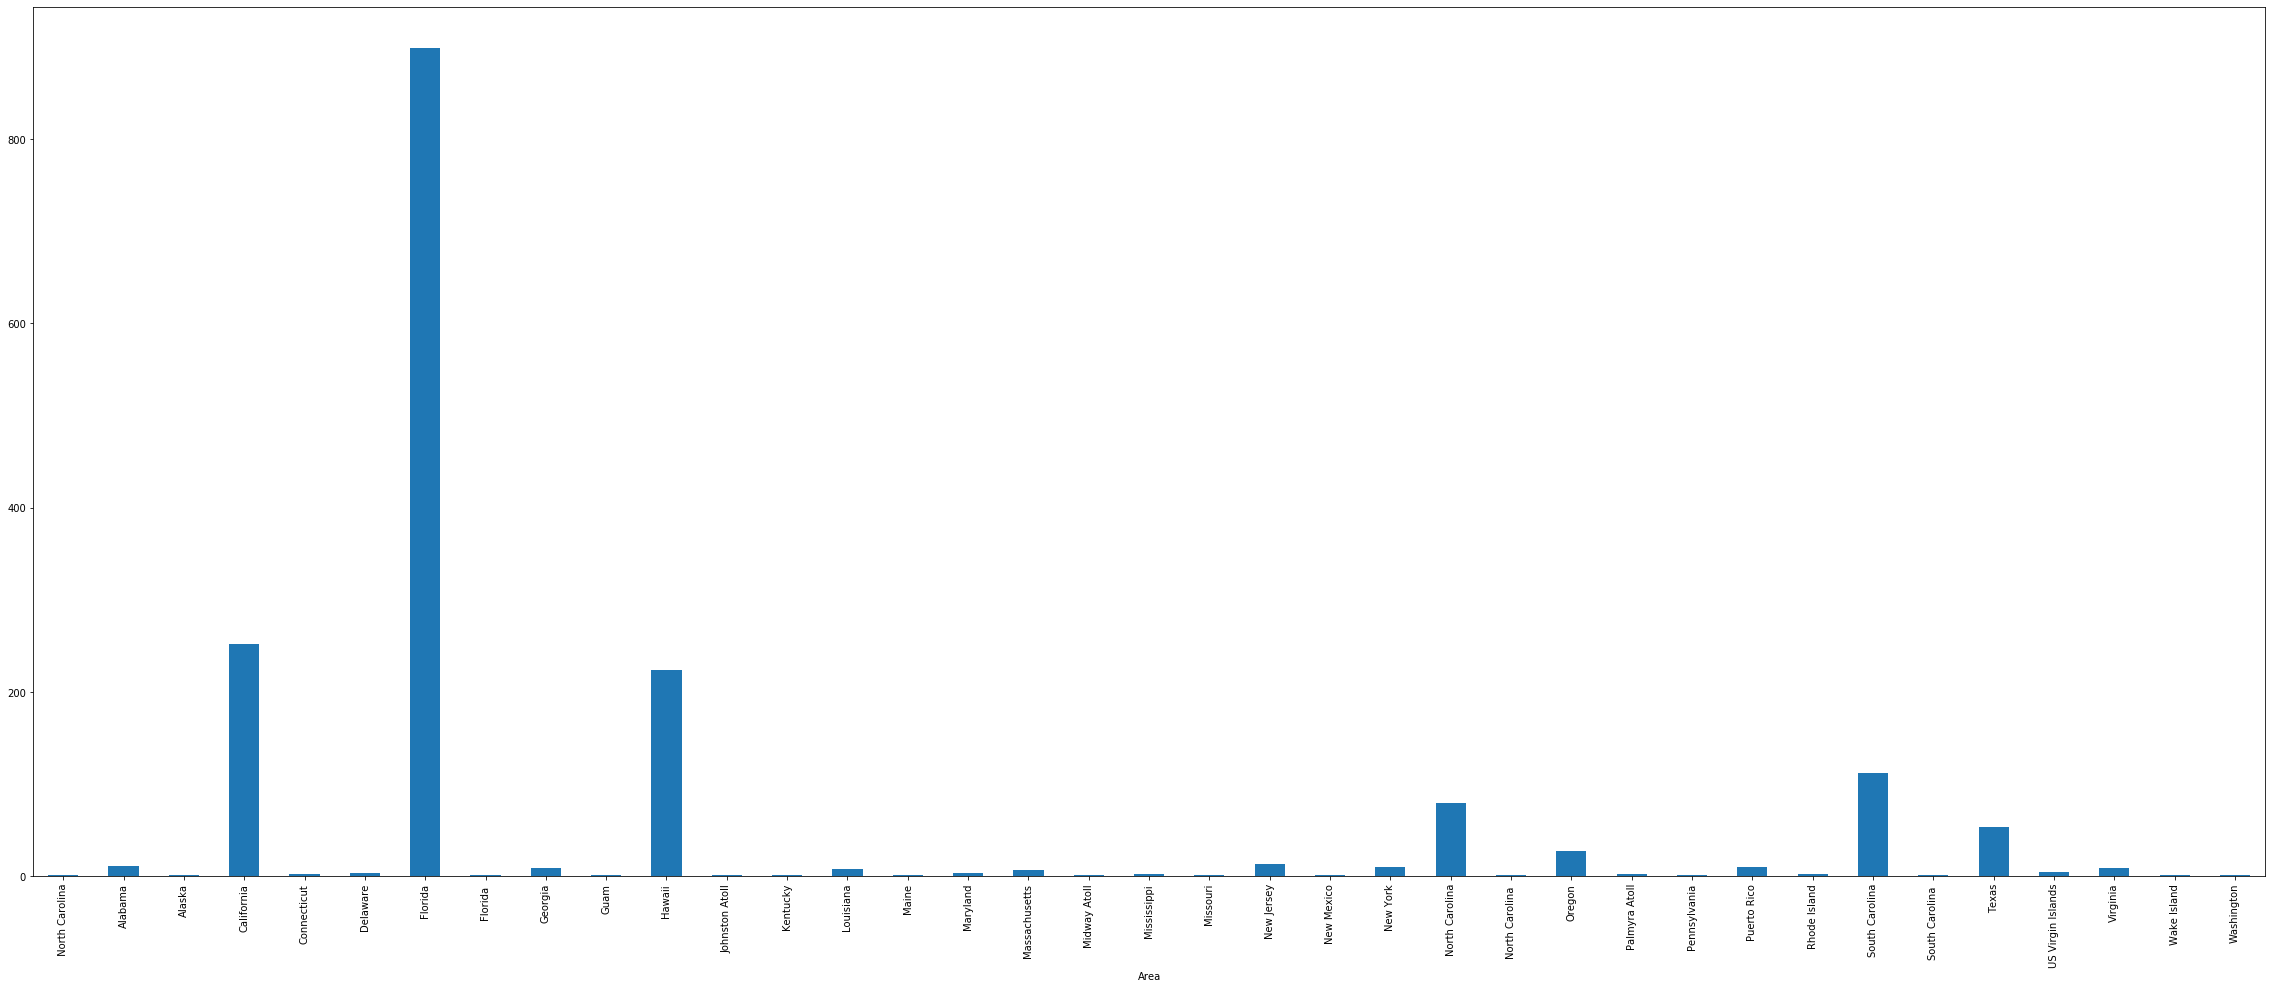

In [32]:
dasa[dasa["Country"]=="USA"].groupby(["Area"]).count()['Fatal'].plot.bar(figsize=(40, 16))

Podemos ver que Florida, California y Hawaii son los estamos con mayor numero de ataques

Hasta aqui sabemos que USA ha sido el pais con mayor numero de ataque y en especial Florida. Tambien sabemos que la actividad con mayor numero de ataques es el Surf

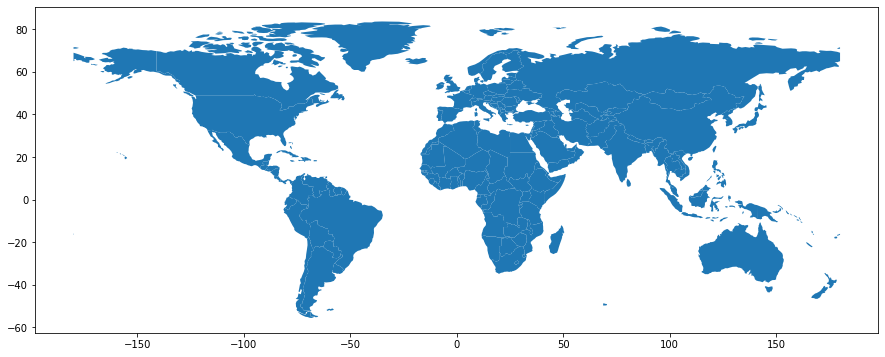

In [33]:
fp="ne_110m_admin_0_countries.shp"
map_df = gpd.read_file(fp)
#print(map_df[map_df['ADMIN'] == 'Antarctica'])
map_df = gdf.drop(gdf.index[159])
map_df.plot(figsize=(40, 6))

In [34]:
map_df.head()

,country,country_code,geometry
0,Fiji,FJI,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,United Republic of Tanzania,TZA,POLYGON ((33.90371119710453 -0.950000000000000...
2,Western Sahara,SAH,POLYGON ((-8.665589565454809 27.65642588959236...
3,Canada,CAN,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,United States of America,USA,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [47]:
merga1 = merga.reset_index().rename_axis(None).rename_axis(None, axis=1)
merga1.to_csv('ju.csv')
merga1.head()

,Country,Code,frate
0,australia,AUS,0.181701
1,bahamas,BHS,0.083333
2,bangladesh,BGD,1.000000
3,belize,BLZ,0.500000
4,brazil,BRA,0.395833


In [36]:
merged = map_df.set_index("country_code").join(merga1.set_index("Code"))
merged.head()

,country,geometry,Country,frate
country_code,,,,
FJI,Fiji,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",fiji,0.351351
TZA,United Republic of Tanzania,POLYGON ((33.90371119710453 -0.950000000000000...,tanzania,0.750000
SAH,Western Sahara,POLYGON ((-8.665589565454809 27.65642588959236...,NaN,NaN
CAN,Canada,"(POLYGON ((-122.84 49.00000000000011, -122.974...",NaN,NaN
USA,United States of America,"(POLYGON ((-122.84 49.00000000000011, -120 49....",united states,0.075957


In [37]:
prueba1 = prueba.reset_index().rename_axis(None).rename_axis(None, axis=1)
prueba1.head()

,index,Year,Country,Fatal,Code
0,0,2016,united states,N,USA
1,1,2016,united states,N,USA
2,2,2016,united states,N,USA
3,3,2016,united states,N,USA
4,4,2016,united states,N,USA


In [38]:
merged = map_df.set_index("country_code").join(prueba1.set_index("Code"))

In [40]:
from IPython.display import IFrame
IFrame('https://datawrapper.dwcdn.net/BWsBf/1/', width=1000, height=600)

In [48]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d


In [42]:
cos=pd.DataFrame()

In [43]:
cos = dasa[dasa["Country"]=="USA"]
cos1 =cos.drop(columns=["Activity", "Sex","Type","Month", "Injury", "original order"])
pan=pd.DataFrame()
cos1.head()

,Year,Country,Area,Fatal
0,2016,USA,Florida,N
1,2016,USA,Florida,N
2,2016,USA,Florida,N
6,2016,USA,Florida,N
7,2016,USA,Hawaii,N


In [44]:
pan["dead"] = cos1[cos1["Fatal"]=="Y"].groupby(["Area",]).count()["Fatal"]
pan["no dead"] = cos1[cos1["Fatal"]=="N"].groupby(["Area"]).count()["Fatal"]
pan["no dead"].fillna(0, inplace=True)
pan["frate"] = pan["dead"]/ (pan["dead"]+ pan["no dead"])
pan.head()

,dead,no dead,frate
Area,,,
North Carolina,1,0.0,1.000000
California,24,227.0,0.095618
Florida,37,856.0,0.041433
Florida,1,0.0,1.000000
Georgia,1,8.0,0.111111


In [51]:
pan1 = pan.reset_index().rename_axis(None).rename_axis(None, axis=1)
pan1
pan2= pan1[]
pan2

,Area,dead,no dead,frate
0,North Carolina,1,0.0,1.000000
1,California,24,227.0,0.095618
2,Florida,37,856.0,0.041433
3,Florida,1,0.0,1.000000
4,Georgia,1,8.0,0.111111
5,Hawaii,41,179.0,0.186364
6,Louisiana,1,7.0,0.125000
7,Maryland,1,3.0,0.250000
8,New York,1,9.0,0.100000
9,North Carolina,6,74.0,0.075000


<BarContainer object of 17 artists>

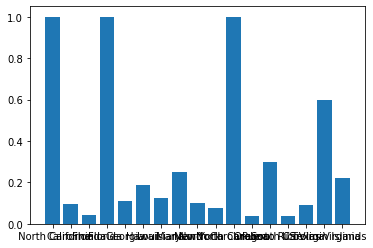

In [46]:
%matplotlib inline
#pan1["frate"].plot.bar(color='blue', figsize=(20, 7))
#sas["frate"].plot.bar(color='blue', figsize=(20, 7))
#dasa[dasa["Country"]=="USA"].groupby(["Area"]).count()['Fatal'].plot.bar(figsize=(40, 16))
plt.bar(pan1["Area"], pan1["frate"])